# Real Dataset Example

This notebook demonstrates surv_bart's applicaiton using a real world dataset.

For simplicity, the dataset is aquired from the lifelines package. Survival analyses and evaluation is first done with the surv_bart package. Then a comparison is made with a COXPH model from the lifelines package.

In [211]:
import lifelines as ll
import numpy as np
from bart_survival import surv_bart as sb
from bart_survival import simulation as sm
import matplotlib.pyplot as plt
import pandas as pd

## Prepare Data

Data is loaded from lifelines.

`week` is the time of event (column index 0) and `arrest` is the event outcome (column index 1).

In [209]:
from lifelines.datasets import load_rossi

rossi = load_rossi()
names = rossi.columns.to_numpy()
print(f"Col names {names}")
rossi = rossi.to_numpy()
print(rossi[:5, :])
print(f"Max time {rossi[:,0].max()}")

Col names ['week' 'arrest' 'fin' 'age' 'race' 'wexp' 'mar' 'paro' 'prio']
[[20  1  0 27  1  0  0  1  3]
 [17  1  0 18  1  0  0  1  8]
 [25  1  0 19  0  1  0  1 13]
 [52  0  1 23  1  1  1  1  1]
 [52  0  0 19  0  1  0  1  3]]
Max time 52


### Prepare the data for BART analyses.

Since the max time is 52 days, the time data is reduced by a factor of 7 (weekly). 

To demonstrate that downscaleing the data is appropriate, two kaplain meier curves are displayed. A direct km curve shows SV probability at each day times and the scale km curve shows SV probability at the scale time of every 7th day.

In comparison of the two, it can be seen that at every 7th day the SV probability is equivalent between the two curves. Essentially, what this demonstrates, is that even when the time is scaled the same number of events occur up to that time point meaning that the SV probability will be the same at these time-points when observing each single day directly or cumulatively up to the scaled time-point.


In [210]:
t_scale = sb.get_time_transform(rossi[:,0], time_scale=7)
y_sk = sb.get_y_sklearn(rossi[:,1], t_scale)
trn = sb.get_surv_pre_train(y_sk, rossi[:,2:], weight=None)
post_test = sb.get_posterior_test(y_sk = y_sk, x_test = rossi[:,2:])

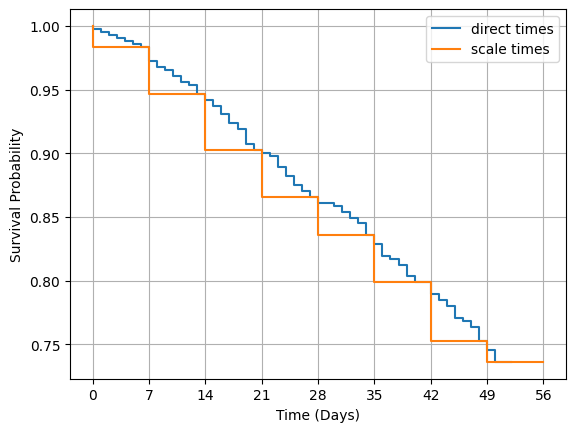

In [242]:
kpm = ll.KaplanMeierFitter()
kpm.fit(rossi[:,0], rossi[:,1])
direct = np.hstack([kpm.survival_function_.index.to_numpy().reshape(-1,1), 
                kpm.survival_function_.to_numpy().reshape(-1,1)])

kpm = ll.KaplanMeierFitter()
kpm.fit(t_scale, rossi[:,1])
scale = np.hstack([kpm.survival_function_.index.to_numpy().reshape(-1,1) * 7, # note multiply by 7 to reset scale to the same units 
                kpm.survival_function_.to_numpy().reshape(-1,1)])


plt.step(direct[:,0], direct[:,1], label = "direct times")
plt.step(scale[:,0], scale[:,1], label = "scale times")
plt.xticks(scale[:,0])
plt.xlabel("Time (Days)")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid()


## Initiate the surv_bart Model

Again, the `split_rules` must be explicitly defined for each variable.

Number of trees is set to 50 as a baseline.

200 tune/draws * 8 chains = 1600 samples is on the low-end of appropriate samples to create the posterior, but in this case it is sufficient.
- After training the model, the pymc model object can be accessed from the surv_bart class directly and pymc specific evaluation metrics can be applied. They are not shown here, but the pymc_bart documentation has examples of utility.

In [29]:
SPLIT_RULES =  [
    "pmb.ContinuousSplitRule()", # time
    "pmb.OneHotSplitRule()", # fin
    "pmb.ContinuousSplitRule()",  # age
    "pmb.OneHotSplitRule()", # race
    "pmb.OneHotSplitRule()", # wexp
    "pmb.OneHotSplitRule()", # mar
    "pmb.OneHotSplitRule()", # paro
    "pmb.ContinuousSplitRule()", # prio
]


model_dict = {"trees": 50,
    "split_rules": SPLIT_RULES
}
sampler_dict = {
            "draws": 200,
            "tune": 200,
            "cores": 8,
            "chains": 8,
            "compute_convergence_checks": False
        }

BSM = sb.BartSurvModel(model_config=model_dict, sampler_config=sampler_dict)

In [30]:
# Fit Model
BSM.fit(
    y =  trn["y"],
    X = trn["x"],
    weights=trn["w"],
    coords = trn["coord"],
    random_seed=5
)

Only 200 samples in chain.
Multiprocess sampling (8 chains in 8 jobs)
PGBART: [f]


Sampling 8 chains for 200 tune and 200 draw iterations (1_600 + 1_600 draws total) took 76 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data
	> predictor_names
	> offset

In [31]:
# Get posterior predictive for evaluation.
post1 = BSM.sample_posterior_predictive(X_pred=post_test["post_x"], coords=post_test["coords"])

Sampling: [f]


In [32]:
# Convert to SV probability.
sv_prob = sb.get_sv_prob(post1)

Below is a plot of the SV probability.

- Red is a sample of distinct patient's predicted SV probability curves.
- Black solid(dash) is the predicted mean sv probability of cohort and 95% Credible Interval. 
- Blue is the KM estimated of SV probability.

A simple check for fit is comparing the KM estimate and the predicted mean(CI). These two curves should be similar as they are both demonstrating the average SV probability at time for the whole cohort.

Text(0.5, 1.0, 'SV Probability')

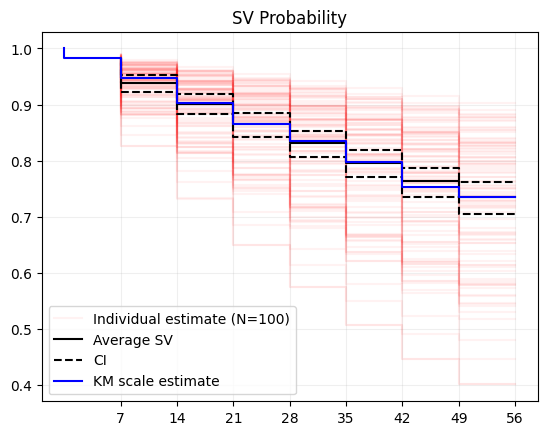

In [285]:
sv_ave = sv_prob["sv"].mean(0) # mean value per draw
N = sv_ave.shape[0]
tttimes = np.unique(y_sk["Survival_in_days"]) * 7 # times by 7 to get back to day scale

# plot sv individual
for i in range(1,100):
    plt.step(tttimes, sv_ave[i,:], color = "red", alpha =0.05)
plt.step(tttimes, sv_ave[0,:], color = "red", alpha =0.05, label = "Individual estimate (N=100)")

# plt sv mean estimate
plt.step(tttimes, sv_ave.mean(0), label = "Average SV", color="black")
ci = np.quantile(sv_prob["sv"].mean(1), [0.025,0.975], axis=0)
plt.step(tttimes, ci[0,:], linestyle="--", color = "black")
plt.step(tttimes, ci[1,:], linestyle="--", color = "black", label = "CI")

# plt km estimate
plt.step(scale[:,0], scale[:,1], color="blue", label="KM scale estimate")
plt.xticks(tttimes)
plt.legend()
plt.grid(alpha=0.2)
plt.title("SV Probability")


## Hazard Ratios (Risk Ratios)

Hazard Ratios are common outcomes desired from survival analyses. The HR is typically evaluated by taking the ratio of the hazard rate $$(\beta(x+1))/(
\beta(x))$$ or the ratio of hazard rates of a 1 unit change in the x value.

In the case of surv_bart, this is derived from the Friedman Partial Dependence functions to generate marginal distributions of a covariate.

For binary outcomes, this is simply $h(x=1)/h(x=0)$, but with continuous or categorical variable (>2) this evaluation can be more complex.
- For continuous variables the simple solution is to take the ratio of the 75th and 25th quantiles. The interpretation of this result must be explicitly stated, as the result will be different than that found through a COXPH model when the effect on hazard rate is not constant across the range of the continuous variable.
- For categorical variables (>2) it is necessary to define the reference value for which to make comparison. As categorical variablees do not need to by one-hot encoded in surv-bart, defining a reference value for the HR derivation will provide results similar to COXPH.

Finally, it is worth noting, that while hazard rate was mentioned several times, the surv_bart model is predicting a risk probability (bounded[0,1]) at each time, not a hazard rate. While they are similar, there are some differences that make it worth noting.

In [86]:
# Get HR for each variable
# Continuous Variables are evaluated at 25th and 75th percentile
HR_L = []
HR_L_long = []
val_list = [[0,1], [20, 27], [0,1], [0,1], [0,1], [0,1], [1,4]]
var_names = ["fin", "age", "race", "wexp", "mar", "paro", "prio"]

for i in range(2,9):
    # get the pdp evaluation
    pdp1 = sb.get_pdp(rossi[:,2:], var_col = [i-2], values = [val_list[i-2]], sample_n = None)
    pdp_tst = sb.get_posterior_test(y_sk, pdp1[0])
    pdp_post = BSM.sample_posterior_predictive(pdp_tst["post_x"], pdp_tst["coords"])
    pdp_sv_prob = sb.get_sv_prob(pdp_post)
    # create a mask to create ratio
    msk_1 = pdp1[1]["coord"] == 1
    # get RR over patietns (leaving draw and time dim)
    rr = (pdp_sv_prob["prob"][:,msk_1,:].mean(1) / pdp_sv_prob["prob"][:,~msk_1,:].mean(1))
    # get RR over draws (leaving time dim)
    RR_M = rr.mean(0)
    # 95 CI over draws (leaving time dim)
    RR_Q = np.round(np.quantile(rr, [0.025, 0.975], axis=0),3)
    # add to list, averaging over time
    HR_L.append((var_names[i-2], RR_M.mean(), RR_Q.mean(1)))
    # add to list, keep seperate times
    HR_L_long.append((var_names[i-2], RR_M, RR_Q))

Sampling: [f]


Sampling: [f]


Sampling: [f]


Sampling: [f]


Sampling: [f]


Sampling: [f]


Sampling: [f]


Displayed below are the mean point estimate and 95% CI for the HR.

"age" and "prio" are the two continuous variables evaluated at the 25th and 75th quantile. The interpretation of these results are different than the COXPH returned HR.

In [154]:
[print(hr) for hr in HR_L]

('fin', 0.7378957431595544, array([0.54975, 0.99575]))
('age', 0.7150946945633692, array([0.4445 , 1.06375]))
('race', 1.339236800263468, array([0.882875, 2.057625]))
('wexp', 0.8232052353782309, array([0.581625, 1.15625 ]))
('mar', 0.7994192541933046, array([0.4885, 1.171 ]))
('paro', 0.9231253232571262, array([0.679 , 1.2005]))
('prio', 1.5966326166577893, array([1.035875, 2.3255  ]))


[None, None, None, None, None, None, None]

A more complex evaluation of the continuous variable can be done through several methods.

Shown below for "age", it is evaluated for each value in the range of the covariate.

In the below code, the `values` parameter is set to the range of "age". This will create a long dataset as each value in the range requires a copy of the full starting dataset. Length will become N * len(range). Use caution when evaluating this way, as the computational time can become quite large due to this expansion.
- `sample_n` provides an ability to downsample the pdp dataset, which can help when estimating pdps, but with loss of precision.

In [167]:
# redo continuous
# check c-index
ages = np.arange(np.unique(rossi[:,3]).min(), np.unique(rossi[:,3]).max())
# do for ages
for i in [3]:
    pdp1 = sb.get_pdp(rossi[:,2:], var_col = [i-2], values = [ages], sample_n = None)
    pdp_tst = sb.get_posterior_test(y_sk, pdp1[0])
    pdp_post = BSM.sample_posterior_predictive(pdp_tst["post_x"], pdp_tst["coords"])
    pdp_sv_prob = sb.get_sv_prob(pdp_post)
    
    tmp_rr = []
    tmp_rr2 = []
    for idx,j in enumerate(ages):
        if idx >= len(ages)-1:
            break
        msk_1 = pdp1[1]["coord"] == idx
        msk_2 = pdp1[1]["coord"] == idx+1
        rr = (pdp_sv_prob["prob"][:,msk_2,:].mean(1) / pdp_sv_prob["prob"][:,msk_1,:].mean(1))
        RR_M = rr.mean(0).mean()
        tmp_rr.append(RR_M)
        RR_Q = np.round(np.quantile(rr, [0.025, 0.975], axis=0),3)
        tmp_rr2.append(RR_Q.mean(1))

Sampling: [f]


The HR can then be averaged over all evaluated values in the range.

In [180]:
# Average HR and CI over times
print(f"HR ave(age+1/age) {np.array(tmp_rr).mean()}")
print(f"HR ave(age+1/age) CI {np.array(tmp_rr2).mean(0)}")

HR ave(age+1/age) 0.9769845971438301
HR ave(age+1/age) CI [0.80274519 1.11419231]


Or HR can be evaluated by examining the distinct values in the range. 

In the plot below, the distinct HR and CI are shown. At each distinct "age", the HR was evaluated by that value/value-1, which gives the 1 unit change HR.

In the plot it can be seen that the HR is not constant over the range of age. The lower age ranges appear to have a lower HR that then rises to a constant value in the medium-upper age ranges.

The average over all the values is shown in red and the underlying distribution of the frequency of the values is shown in light blue.

Text(0, 0.5, 'freq')

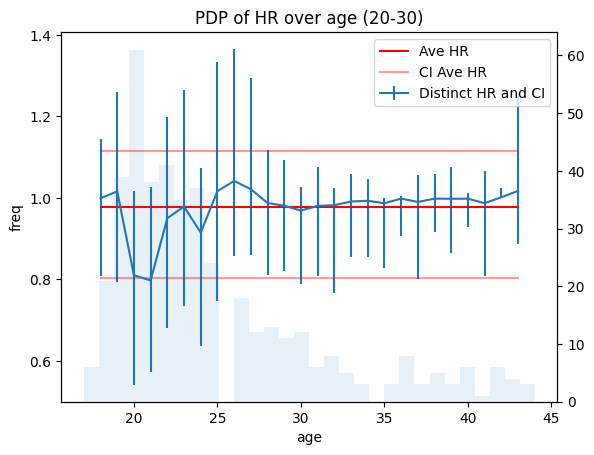

In [179]:
ttt = ages[1:]
diff = np.abs(tmp_rr - np.array(tmp_rr2).T)
fig, ax  = plt.subplots()
ax.errorbar(ttt, y = tmp_rr, yerr=diff, label = "Distinct HR and CI")
ax.plot(ttt, np.repeat(np.array(tmp_rr).mean(), len(ttt)), color = "red", label="Ave HR")
ax.plot(ttt, np.repeat(np.array(tmp_rr2).mean(0)[0], len(ttt)), color = "red", alpha=0.4, label= "CI Ave HR")
ax.plot(ttt, np.repeat(np.array(tmp_rr2).mean(0)[1], len(ttt)), color = "red", alpha=0.4)
ax.set_xlabel("age")
ax.set_ylabel("HR")
ax.set_title("PDP of HR over age (20-30)")
ax.legend()
ax2 = ax.twinx()
ax2.hist(rossi[:,3], bins = 30, alpha=.1)
ax.set_ylabel("freq")

It is import to be explicit in interpretation of HR depending on the method.
When derived as $\text{HR}_{25th,75th}$ the value was 0.72. A seen in the plot above the difference between HR at ages 20 and 27 is the largest in the set. 

In the $\text{HR}_{+1}$ evaluation, the averaged value is 0.97. 

While neither of these are wrong, explicit description of the measurement must be made to denote the difference.

Similar evaluation can be done for the "prio" variable.

In [186]:
prio = np.arange(np.unique(rossi[:,-1]).min(), np.unique(rossi[:,-1]).max())
# do for prio
for i in [8]:
    pdp1 = sb.get_pdp(rossi[:,2:], var_col = [i-2], values = [prio], sample_n = None)
    pdp_tst = sb.get_posterior_test(y_sk, pdp1[0])
    pdp_post = BSM.sample_posterior_predictive(pdp_tst["post_x"], pdp_tst["coords"])
    pdp_sv_prob = sb.get_sv_prob(pdp_post)
    
    tmp_rr = []
    tmp_rr2 = []
    for idx,j in enumerate(prio):
        if idx >= len(prio)-1:
            break
        msk_1 = pdp1[1]["coord"] == idx
        msk_2 = pdp1[1]["coord"] == idx+1
        rr = (pdp_sv_prob["prob"][:,msk_2,:].mean(1) / pdp_sv_prob["prob"][:,msk_1,:].mean(1))
        RR_M = rr.mean(0).mean()
        tmp_rr.append(RR_M)
        RR_Q = np.round(np.quantile(rr, [0.025, 0.975], axis=0),3)
        tmp_rr2.append(RR_Q.mean(1))

Sampling: [f]


In [187]:
print(f"HR ave(prio+1/prio) {np.array(tmp_rr).mean()}")
print(f"HR ave(prio+1/prio) CI {np.array(tmp_rr2).mean(0)}")

HR ave(prio+1/prio) 1.0357986908239425
HR ave(prio+1/prio) CI [0.93263971 1.21379412]


Text(0, 0.5, 'freq')

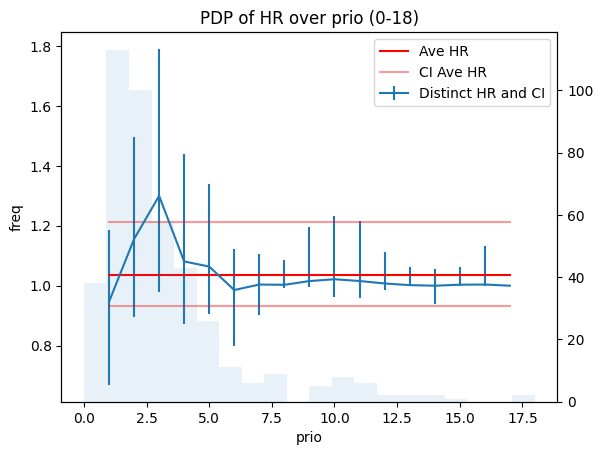

In [191]:
ttt = prio[1:]
diff = np.abs(tmp_rr - np.array(tmp_rr2).T)
fig, ax  = plt.subplots()
ax.errorbar(ttt, y = tmp_rr, yerr=diff, label = "Distinct HR and CI")
ax.plot(ttt, np.repeat(np.array(tmp_rr).mean(), len(ttt)), color = "red", label="Ave HR")
ax.plot(ttt, np.repeat(np.array(tmp_rr2).mean(0)[0], len(ttt)), color = "red", alpha=0.4, label= "CI Ave HR")
ax.plot(ttt, np.repeat(np.array(tmp_rr2).mean(0)[1], len(ttt)), color = "red", alpha=0.4)
ax.set_xlabel("prio")
ax.set_ylabel("HR")
ax.set_title("PDP of HR over prio (0-18)")
ax.legend()
ax2 = ax.twinx()
ax2.hist(rossi[:,-1], bins = 20, alpha=.1)
ax.set_ylabel("freq")

In the "prio" variable, the HR is not constant over all single steps.

An interpretation could be that going from 1 prior arrest to 2 prior arrests increases risk, and similarily with 2 to 3. After 3 prior arrests, increasing the number of prior offenses has little effect on the outcome.

The $\text{HR}_{25th,75th}$ = 1.6, which is quite different than the average single step $\text{HR}_{+1}$ of 1.04. 

Again, neither of these values are wrong, they are simply describing different things.

## COXPH 

Evaluate the data with a standard COXPH model.

In [192]:
rossi2 = load_rossi()
cph = ll.CoxPHFitter()
cph.fit(rossi2, duration_col='week', event_col='arrest')

cph.print_summary()  # access

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -658.75
         time fit was run = 2024-02-12 21:03:14 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
fin       -0.38      0.68      0.19           -0.75           -0.00                0.47                1.00
age       -0.06      0.94      0.02           -0.10           -0.01                0.90                0.99
race       0.31      1.37      0.31           -0.29            0.92                0.75                2.50
wexp      -0.15      0.86      0.21           -0.57            0.27                0.57                1.30
mar       -0.43      0.65      0.38           -1.18            0.31                0.31                1.37
paro      -0.08      0.92      0.20           -0.47            0.30                0.63                1.35
prio       0.09      1.10      0.03            0.04            0.15                1.04                1.16

           cmp to     z      p  -log2(p)
covariate                               
fin          0.00 -1.98   0.05      4.40
age          0.00 -2.61   0.01      6.79
race         0.00  1.02   0.31      1.70
wexp         0.00 -0.71   0.48      1.06
mar          0.00 -1.14   0.26      1.97
paro         0.00 -0.43   0.66      0.59
prio         0.00  3.19 <0.005      9.48
---
Concordance = 0.64
Partial AIC = 1331.50
log-likelihood ratio test = 33.27 on 7 df
-log2(p) of ll-ratio test = 15.37

In [292]:
[print(l) for l in HR_L]

('fin', 0.7378957431595544, array([0.54975, 0.99575]))
('age', 0.7150946945633692, array([0.4445 , 1.06375]))
('race', 1.339236800263468, array([0.882875, 2.057625]))
('wexp', 0.8232052353782309, array([0.581625, 1.15625 ]))
('mar', 0.7994192541933046, array([0.4885, 1.171 ]))
('paro', 0.9231253232571262, array([0.679 , 1.2005]))
('prio', 1.5966326166577893, array([1.035875, 2.3255  ]))


[None, None, None, None, None, None, None]

Comparison of the COXPH HRs and surv_bart HRs reveals fairly consistent values across variables. The major exceptions being the continuous variables "age" and "prio". However, as discussed above, these HRs are derived differently than in the COXPH model and have different interpretations.

When considering the $\text{HR}_{+1}$ for each "age" and "prio", the value is more consistent with the COXPH HRs.